In [1]:
import json
import glob
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
REVAL_DIR = os.path.expanduser('~/reval_05')
sys.path.append('..')
from imports import *

In [2]:
files = glob.glob(f'{REVAL_DIR}/*/*/rich_results.json')

results = [load(f) for f in files]

from itertools import groupby
gb = lambda it, key: groupby(sorted(it, key=key), key)

for key, group in gb(results, lambda x: x['model']):
    print(key, end=' ')

R101 R101_C4 R101_DC5 R101_FPN R50 R50_C4 R50_DC5 R50_FPN X101 

In [3]:
sum(int(r['elapsed']) for r in results)

1054712

In [4]:
def flatten(value):
    if 'results' not in results:
        return value
    result = value.copy()
    aps = {k: v for k, v in result['results']['bbox'].items() if '-' not in k}
    result.update(aps)
    del result['results']
    return result
# flatten(results[0])

In [5]:
c_df = pd.DataFrame([flatten(r) for r in results]).sort_values(['model', 'quality'])
c_df.head()

,quality,model,elapsed,tp,fp,ex,precision,recall,f1,min_score,score_T,AP,AP50,AP75,APs,APm,APl
51,1,R101,662.250143,2033,290680,3114,0.006945,0.055952,0.012357,0.05,None,0.850949,1.641063,0.786802,0.337162,0.724543,1.691920
40,2,R101,662.124931,2037,291295,3113,0.006944,0.056062,0.012358,0.05,None,0.858069,1.641554,0.785646,0.262078,0.734832,1.670085
28,3,R101,663.974067,2806,339793,3594,0.008190,0.077226,0.014810,0.05,None,1.156743,2.214548,0.989994,0.407562,1.075822,2.199633
47,4,R101,666.866484,4852,386532,5813,0.012397,0.133535,0.022688,0.05,None,1.964670,3.590941,1.862873,0.551889,2.125328,3.530575
17,5,R101,668.412551,7667,412795,8597,0.018235,0.211009,0.033569,0.05,None,3.296703,5.965182,3.181081,1.059228,3.860601,5.428963


In [8]:
for mc in c_df.model.unique():
    ax = c_df[c_df.model == mc][['quality', 'AP', 'AP50', 'AP75']].plot(x='quality')
    ax.set_title(mc)
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/1-APx-{mc}")
    plt.close() # prevent show

Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R101.png and 2021-03-01-Plot_reval_05_APs/APx-R101.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R101_C4.png and 2021-03-01-Plot_reval_05_APs/APx-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R101_DC5.png and 2021-03-01-Plot_reval_05_APs/APx-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R101_FPN.png and 2021-03-01-Plot_reval_05_APs/APx-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R50.png and 2021-03-01-Plot_reval_05_APs/APx-R50.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R50_C4.png and 2021-03-01-Plot_reval_05_APs/APx-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R50_DC5.png and 2021-03-01-Plot_reval_05_APs/APx-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-R50_FPN.png and 2021-03-01-Plot_reval_05_APs/APx-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/APx-X101.png and 2021-03-01-Plot_reval_05_APs/APx-X101.pdf


In [10]:
avg_pivot = c_df.pivot_table(index='model', values=['AP', 'APl', 'APm', 'APs']).sort_values('AP', ascending=False)
avg_pivot

,AP,APl,APm,APs
model,,,,
X101,34.927685,45.920218,37.778516,20.122565
R101_FPN,34.167798,45.743412,37.028163,19.025153
R101_C4,33.608163,47.307410,37.294725,16.611395
R101_DC5,33.227068,45.751765,36.755736,16.885205
R101,32.810577,43.515592,36.124342,17.436166
R50_FPN,32.528388,43.335347,35.291713,18.184412
R50_DC5,31.721918,43.682657,35.189993,16.106194
R50,31.080935,41.548232,34.032183,16.989777
R50_C4,31.079360,44.221552,34.446147,15.153276


In [9]:
def _save_plot(plot, name='', title=None):
    if title:
        plot.set_title(title)
    fig = plot.get_figure()
    fig.set_size_inches(4, 4)
    if name:
        fig.savefig(name)

def plot_models(df, column, norm=False):
    avg_pivot = df.pivot_table(index='model', values=[column]).sort_values(column, ascending=False)
    c_pivot = df.pivot(index='quality', columns='model', values=column).reindex(columns=avg_pivot.index)
    title = f'{column}: all models'
    if norm:
        c_pivot = c_pivot / c_pivot.max(axis=0)
        title += ' (scaled)'
    ax = c_pivot.plot()
    ax.set_title(title)
    return ax


In [11]:
ax = plot_models(c_df, 'AP')
# _save_plot(ax, 'all_AP_raw.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/2-all_AP_raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/2-all_AP_raw.png and 2021-03-01-Plot_reval_05_APs/2-all_AP_raw.pdf


In [12]:
ax = plot_models(c_df, 'AP', True)
_save_plot(ax, 'all_AP_scaled.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/3-all_AP_scaled")
plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/3-all_AP_scaled.png and 2021-03-01-Plot_reval_05_APs/3-all_AP_scaled.pdf


In [13]:
for mc in c_df.model.unique():
    ax = c_df[c_df.model == mc][['quality', 'APs', 'APm', 'APl']].plot(x='quality')
    ax.set_title(mc)
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/4-APsml-{mc}")
    plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R101.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R101.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R101_C4.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R101_DC5.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R101_FPN.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R50.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R50.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R50_C4.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R50_DC5.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-R50_FPN.png and 2021-03-01-Plot_reval_05_APs/4-APsml-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/4-APsml-X101.png and 20

In [14]:
pd.pivot(c_df, index='quality', columns='model', values=['APs', 'APm', 'APl']).plot();
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/5-APsml-all")
plt.close();

Figure saved to 2021-03-01-Plot_reval_05_APs/5-APsml-all.png and 2021-03-01-Plot_reval_05_APs/5-APsml-all.pdf


In [17]:
mAPsml = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))})
mAPsml = mAPsml / mAPsml.max(axis=0)
plot = mAPsml.plot()
_save_plot(plot, 'average_APlms_scaled.pdf', 'Per-size AP (scaled)')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/6-APsml-allavg-scaled")
plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/6-APsml-allavg-scaled.png and 2021-03-01-Plot_reval_05_APs/6-APsml-allavg-scaled.pdf


In [18]:
plot = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))}).plot()
_save_plot(plot, 'average_APlms.pdf', "Per-size AP (large, medium, small)")
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/7-APsml-allavg-raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/7-APsml-allavg-raw.png and 2021-03-01-Plot_reval_05_APs/7-APsml-allavg-raw.pdf


# "Rich" results, with TPR, PPV and F1
Computed for Tc = 0.5

In [21]:
rich_files = glob.glob(f'{REVAL_DIR}/*/*/rich_results.json')

df = pd.DataFrame(load(f) for f in rich_files).sort_values(['model', 'quality'])
df.tail()

,quality,model,elapsed,tp,fp,ex,precision,recall,f1,min_score,score_T,AP,AP50,AP75,APs,APm,APl
133,97,X101,2950.533190,29538,69427,11885,0.298469,0.812935,0.436630,0.050000,None,43.125026,63.823199,47.014898,27.212577,46.190293,54.863181
175,98,X101,2949.976151,29537,69465,11845,0.298348,0.812908,0.436496,0.050000,None,43.064660,63.628361,46.943094,26.896694,46.098858,54.857996
103,99,X101,2952.297939,29549,69465,11835,0.298433,0.813238,0.436634,0.050000,None,43.101607,63.681584,47.133904,27.035522,46.123877,54.916508
112,100,X101,2952.063746,29549,69454,11853,0.298466,0.813238,0.436670,0.050001,None,43.070649,63.715295,46.980151,26.992763,46.103360,54.878414
406,101,X101,2673.639724,29546,69608,11862,0.297981,0.813155,0.436139,0.050000,None,43.046948,63.651725,46.888371,27.205004,46.093387,54.890155


In [22]:
for mc in df.model.unique():
    ax = df[df.model == mc][['quality', 'precision', 'recall', 'f1']].plot(x='quality')
    ax.set_title(mc)
    _save_plot(ax, f'{mc}_prf1.pdf')
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_05_APs/8-PRF1-{mc}")
    plt.close()

Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R101.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R101.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_C4.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_DC5.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_FPN.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R50.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R50.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_C4.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_DC5.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_FPN.png and 2021-03-01-Plot_reval_05_APs/8-PRF1-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_05_APs/8-PRF1-X101.png and 2021-03-01-Plot_rev

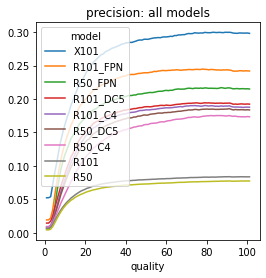

In [24]:
ax = plot_models(df, 'precision')
_save_plot(ax, 'all_PPV_raw.pdf')

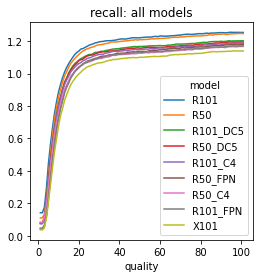

In [22]:
ax = plot_models(df, 'recall')
save_plot(ax, 'all_TPR_raw.pdf')

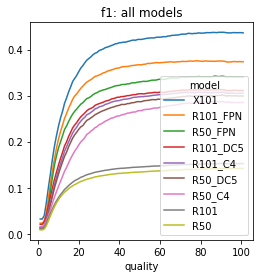

In [25]:
ax = plot_models(df, 'f1')
_save_plot(ax, 'all_F1_raw.pdf')

# Structural similarity (SSIM)

In [26]:
qdf = pd.read_csv('../data/val2017_means_per_Q.csv')
qdf.head(2)

,quality,mean_squared_error,peak_signal_noise_ratio,structural_similarity,filesize,B_per_kpx
0,1,536.18,21.205,0.539,7203.782,9.291
1,2,535.91,21.207,0.539,7207.225,9.295


In [27]:
avgdf = df.groupby('quality').agg('mean')
avgdf.tail(2)

,elapsed,tp,fp,ex,precision,recall,f1,min_score,AP,AP50,AP75,APs,APm,APl
quality,,,,,,,,,,,,,,
100,1144.756110,29614.777778,164210.111111,13742.888889,0.183927,0.815048,0.294050,0.050001,40.381796,60.816121,43.674192,23.457767,44.269027,53.271776
101,1097.117104,29613.444444,164403.333333,13744.888889,0.183683,0.815012,0.293742,0.050001,40.392295,60.849938,43.650912,23.476854,44.283071,53.287806


In [28]:
rich = pd.merge(avgdf, qdf, left_index=True, right_index=True)

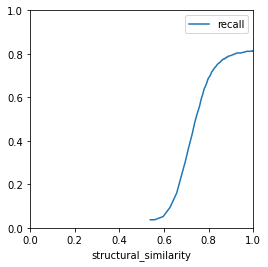

In [30]:
ax = rich.plot(x='structural_similarity', y='recall', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, 'recall_by_ssim.pdf')

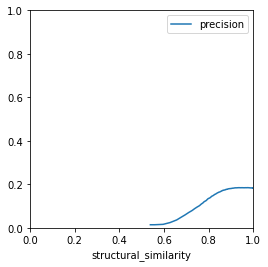

In [31]:
ax = rich.plot(x='structural_similarity', y='precision', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, '')

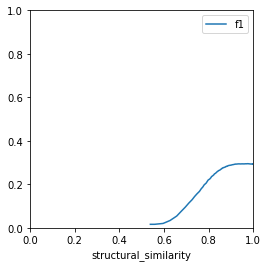

In [32]:
ax = rich.plot(x='structural_similarity', y='f1', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, '')

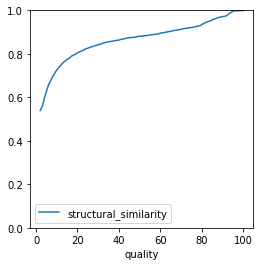

In [46]:
ax = rich.plot(x='quality', y='structural_similarity', ylim=(0, 1))
# , xlabel="jakość JPEG (Q)", ylabel="wartość SSIM", legend=False
_save_plot(ax, 'SSIM_by_q.pdf')

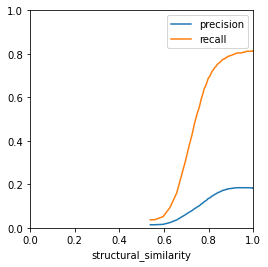

In [34]:
ax = rich[['structural_similarity', 'precision', 'recall']].plot(x='structural_similarity', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, 'pr_by_SSIM.pdf')

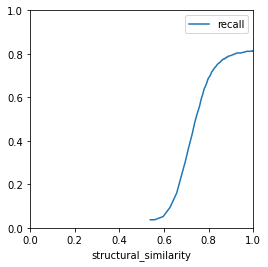

In [35]:
ax = rich.plot(x='structural_similarity', y='recall', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, '')

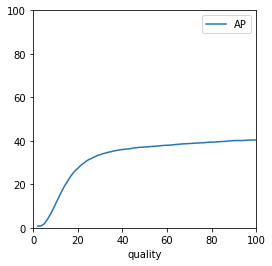

In [36]:
ax = rich.plot(x='quality', y='AP', ylim=(0, 100), xlim=(0, 100))
_save_plot(ax, '')

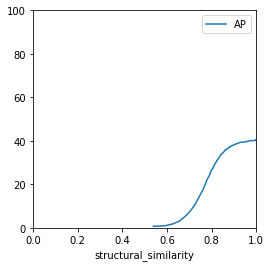

In [37]:
ax = rich.plot(x='structural_similarity', y='AP', xlim=(0, 1), ylim=(0, 100))
_save_plot(ax, 'AP_by_SSIM.pdf')

# Tables

In [38]:
rich.loc[[96, 90, 80, 60, 40, 20], ['AP', 'APl', 'APm', 'APs']].round(1).reset_index()

,index,AP,APl,APm,APs
0,96,40.3,53.2,44.2,23.5
1,90,40.1,53.1,43.9,23.3
2,80,39.4,52.5,43.0,22.1
3,60,38.0,51.3,41.7,20.0
4,40,36.1,49.5,39.6,18.2
5,20,28.4,40.1,31.1,13.1


In [41]:
rich['PPV'] = rich.precision * 100
rich['TPR'] = rich.recall * 100
rich['SSIM'] = rich.structural_similarity * 100
rich['size'] = rich.filesize / 1024
print(rich
     .replace('precision', 100 * rich.precision)
     .set_index('quality')
     .loc[
         [96, 90, 80, 60, 40, 20, 10],
         ['AP', 'AP50', 'AP75', 'APl', 'APm', 'APs', 'TPR', 'PPV', 'SSIM', 'size']
     ]
     #.reset_index()
     .round(1)
     .to_latex()
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    AP &  AP50 &  AP75 &   APl &   APm &   APs &   TPR &   PPV &  SSIM &   size \\
quality &       &       &       &       &       &       &       &       &       &        \\
\midrule
96      &  40.3 &  60.7 &  43.5 &  53.2 &  44.2 &  23.5 &  81.4 &  18.4 &  99.9 &  167.1 \\
90      &  40.1 &  60.5 &  43.2 &  53.1 &  43.8 &  23.2 &  81.2 &  18.5 &  97.1 &  107.0 \\
80      &  39.4 &  59.6 &  42.4 &  52.5 &  43.0 &  22.2 &  80.5 &  18.5 &  93.4 &   74.6 \\
60      &  37.9 &  57.8 &  40.8 &  51.3 &  41.5 &  20.1 &  79.1 &  18.1 &  89.5 &   46.5 \\
40      &  36.0 &  55.5 &  38.4 &  49.4 &  39.6 &  18.3 &  77.5 &  17.3 &  86.3 &   33.9 \\
20      &  27.3 &  44.2 &  28.5 &  38.5 &  30.2 &  12.6 &  69.7 &  13.8 &  80.5 &   21.3 \\
10      &  10.8 &  18.7 &  10.8 &  15.9 &  12.3 &   4.8 &  43.0 &   8.0 &  72.6 &   13.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3717/700065347.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex()
